# Interpolation Demo: Zero-Stuffing + Low-Pass Filtering

Mat Vallejo; PhD Candidate in Sound Recording, McGill University

This interactive demonstration illustrates the process of upsampling a discrete-time signal by an integer factor **L** using the classic two-step approach:

1. **Zero-stuffing** (insertion of L-1 zeros between samples)
2. **Low-pass filtering** (anti-imaging filter)

The demo explicitly shows the consequences of using an incorrectly designed anti-imaging filter.

## 1. Setup and Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, RadioButtons, interactive_output, VBox, HBox
import ipywidgets as widgets
from IPython.display import display

# Use inline backend (works everywhere)
%matplotlib inline

# Set default figure size
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['figure.dpi'] = 100

print("✓ Imports successful")

✓ Imports successful


In [4]:
%matplotlib inline
from ipywidgets import interact, IntSlider

@interact(x=IntSlider(min=1, max=10, value=5))
def test(x):
    print(f"Value: {x}")

interactive(children=(IntSlider(value=5, description='x', max=10, min=1), Output()), _dom_classes=('widget-int…

## 2. Signal Processing Functions

In [10]:
# Create a signal

def generate_test_signal(fs, freq_1=440, freq_2=1000, N=256):

    t = np.arange(N) / fs # time vector
    x = np.sin(2 * np.pi * freq_1 * t) + 0.75 * np.sin(2 * np.pi * freq_2 * t)

    return x, t

# Upsample signal by inserting L-1 zeros between each sample.
# This operation increases the sampling rate by factor L but introduces
# spectral images at integer multiples of the original sampling frequency.

def zero_stuff(x, L):

    y = np.zeros(len(x) * L)
    y[::L] = x

    return y

# Design a windowed-sinc low-pass filter using the Hamming window.
# The ideal lowpass filter has an impulse response h[n] = sinc(ωc*n).
# Windowing provides a practical FIR approximation.

def design_sinc_lpf(cutoff, fs, numtaps=101):

    n = np.arange(numtaps) - numtaps // 2 #symmetric
    omega_c = 2 * np.pi * cutoff / fs
    h = np.sinc(omega_c * n / np.pi)
    h *= np.hamming(numtaps)
    h /= np.sum(h)  # Normalize for unity gain at DC

    return h

# Apply anti-imaging low-pass filter to zero-stuffed signal.
# "correct": cutoff at fs_orig/2 (removes images)
# "naive": cutoff at fs_up/2 (leaves images intact)

def apply_interpolation_filter(x_upsampled, fs_up, fs_orig, mode="correct"):

    if mode == "naive":
        cutoff = 0.5 * fs_up  # Naive approach: does NOT remove images!
    else:
        cutoff = 0.5 * fs_orig  # Correct approach: removes images

    h = design_sinc_lpf(cutoff, fs_up, numtaps=101)
    y = np.convolve(x_upsampled, h, mode='same')
    y *= fs_up / fs_orig  # Scale to restore original amplitude

    return y, h, cutoff

# Magnitude spectrum computation

def compute_spectrum(x, fs):

    X = np.fft.fftshift(np.fft.fft(x))
    f = np.fft.fftshift(np.fft.fftfreq(len(x), 1/fs))
    return f, np.abs(X)

## 3. Quick Static Examples

- Examine zero-stuffed sequence
- Correct vs naive interpolation
- Check filter impulse response h and frequency response H


In [8]:
# Zero-stuffed sequence
x_test = np.array([1, 2, 3, 4])
x_stuffed = zero_stuff(x_test, L=3)
print("Original:", x_test)
print("Zero-stuffed:", x_stuffed)

Original: [1 2 3 4]
Zero-stuffed: [1. 0. 0. 2. 0. 0. 3. 0. 0. 4. 0. 0.]


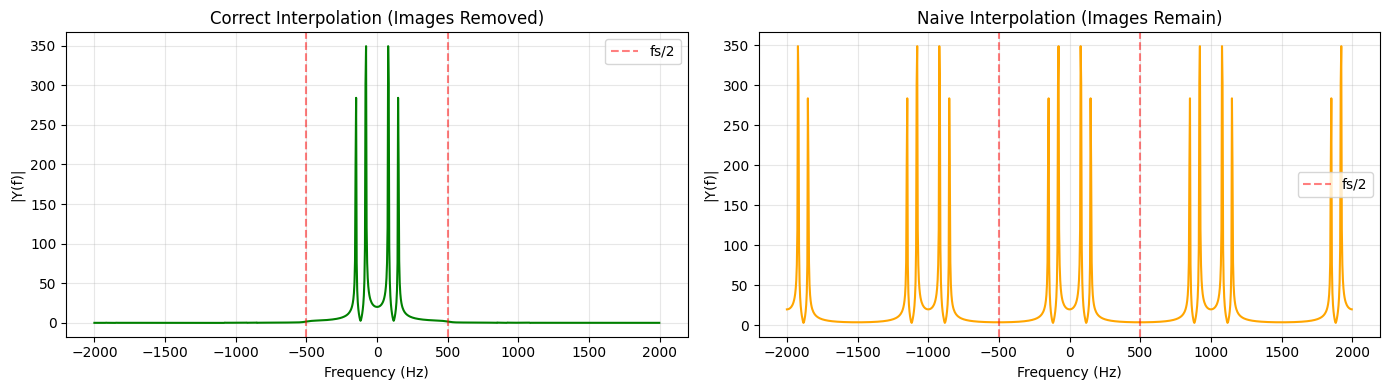

Naive filter leaves spectral images around ±1000 Hz


In [11]:
# Example: Compare correct vs naive interpolation
fs = 1000
L = 4
N = 256

# Generate signal
x, t = generate_test_signal(fs, freq_1=80, freq_2=150, N=N)

# Zero-stuff
x_up = zero_stuff(x, L)
fs_up = fs * L

# Apply both filter modes
y_correct, _, _ = apply_interpolation_filter(x_up, fs_up, fs, mode='correct')
y_naive, _, _= apply_interpolation_filter(x_up, fs_up, fs, mode='naive')

# Compute spectra
f_correct, Y_correct_mag = compute_spectrum(y_correct, fs_up)
f_naive, Y_naive_mag = compute_spectrum(y_naive, fs_up)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(f_correct, Y_correct_mag, 'g-', linewidth=1.5)
axes[0].set_title('Correct Interpolation (Images Removed)')
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('|Y(f)|')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(fs/2, color='r', linestyle='--', alpha=0.5, label='fs/2')
axes[0].axvline(-fs/2, color='r', linestyle='--', alpha=0.5)
axes[0].legend()

axes[1].plot(f_naive, Y_naive_mag, 'orange', linewidth=1.5)
axes[1].set_title('Naive Interpolation (Images Remain)')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('|Y(f)|')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(fs/2, color='r', linestyle='--', alpha=0.5, label='fs/2')
axes[1].axvline(-fs/2, color='r', linestyle='--', alpha=0.5)
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Naive filter leaves spectral images around ±{fs} Hz")

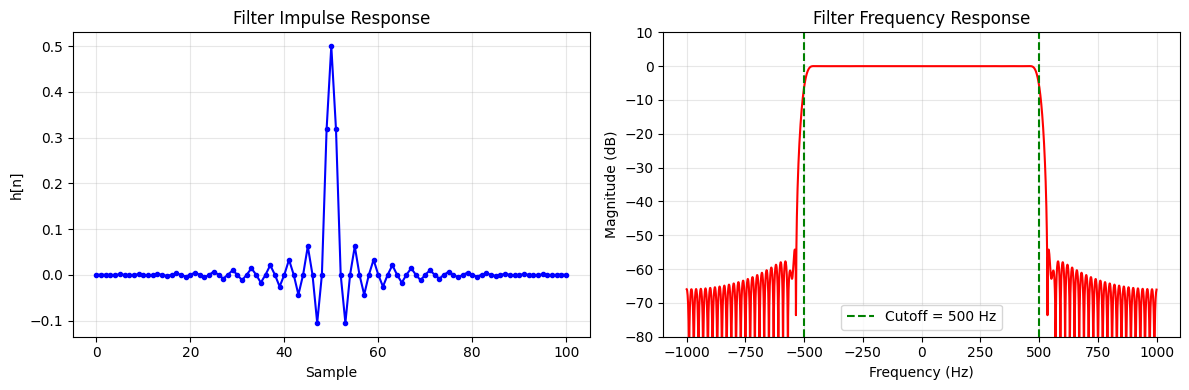

In [26]:
# Visualize filter impulse and frequency response
fs = 2000
cutoff = 500
h = design_sinc_lpf(cutoff, fs, numtaps=101)

# Frequency response
H = np.fft.fftshift(np.fft.fft(h, n=2048))
freqs = np.fft.fftshift(np.fft.fftfreq(2048, 1/fs))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(h, 'b.-')
axes[0].set_title('Filter Impulse Response')
axes[0].set_xlabel('Sample')
axes[0].set_ylabel('h[n]')
axes[0].grid(True, alpha=0.3)

axes[1].plot(freqs, 20*np.log10(np.abs(H) + 1e-10), 'r-')
axes[1].axvline(cutoff, color='g', linestyle='--', label=f'Cutoff = {cutoff} Hz')
axes[1].axvline(-cutoff, color='g', linestyle='--')
axes[1].set_title('Filter Frequency Response')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Magnitude (dB)')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([-80, 10])
axes[1].legend()

plt.tight_layout()
plt.show()

## 4. Interactive Demo

Run the cell below to launch the interactive visualization.

**Controls:**
- **L slider:** Interpolation factor (2-8)
- **fs slider:** Original sampling rate (500-3000 Hz)
- **Radio buttons:** Toggle between correct and naive low-pass filter

In [1]:
# Fixed parameters
N = 256
freq_1 = 80
freq_2 = 150

# Plotting function that gets called when sliders change

def plot_interpolation(L, fs, filter_mode):

    # Determine mode from radio button
    mode = 'correct' if filter_mode == 'Correct (cutoff = fs/2)' else 'naive'

    # Generate original signal
    x, t = generate_test_signal(fs, freq_1, freq_2, N)

    # Step 1: Zero-stuffing & Upsampling
    x_up = zero_stuff(x, L)
    fs_up = fs * L
    t_up = np.arange(len(x_up)) / fs_up

    # Step 2: Interpolation filtering
    y, h, cutoff = apply_interpolation_filter(x_up, fs_up, fs, mode)

    # Compute spectra
    f_orig, X_mag = compute_spectrum(x, fs)
    f_up, X_up_mag = compute_spectrum(x_up, fs_up)
    f_interp, Y_mag = compute_spectrum(y, fs_up)

    # Create figure with subplots
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    fig.suptitle('Interpolation via Zero-Stuffing + Low-Pass Filtering',
                 fontsize=14, fontweight='bold')

    # --- Row 1: Original Signal ---
    axes[0, 0].plot(t * 1000, x, 'b-', linewidth=1.5)
    axes[0, 0].set_xlabel('Time (ms)')
    axes[0, 0].set_ylabel('Amplitude')
    axes[0, 0].set_title(f'Original Signal (fs = {fs} Hz)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_xlim([0, 20])

    axes[0, 1].plot(f_orig, X_mag, 'b-', linewidth=1.5)
    axes[0, 1].axvline(-fs/2, color='r', linestyle='--', alpha=0.5, label='±fs/2')
    axes[0, 1].axvline(fs/2, color='r', linestyle='--', alpha=0.5)
    axes[0, 1].set_xlabel('Frequency (Hz)')
    axes[0, 1].set_ylabel('|X(f)|')
    axes[0, 1].set_title(f'Spectrum of Original Signal (fs = {fs}Hz)')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()
    axes[0, 1].set_xlim([-fs_up/2, fs_up/2])

    # --- Row 2: Zero-Stuffed Signal ---
    axes[1, 0].stem(t_up[:200] * 1000, x_up[:200], linefmt='g-',
                   markerfmt='go', basefmt='gray', label='Zero-stuffed')
    axes[1, 0].plot(t * 1000, x, 'b--', alpha=0.5, linewidth=1, label='Original')
    axes[1, 0].set_xlabel('Time (ms)')
    axes[1, 0].set_ylabel('Amplitude')
    axes[1, 0].set_title(f'After Zero-Stuffing (L = {L})')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()
    axes[1, 0].set_xlim([0, 20])

    axes[1, 1].plot(f_up, X_up_mag, 'g-', linewidth=1.5, label='Zero-stuffed')
    axes[1, 1].axvline(-fs/2, color='r', linestyle='--', alpha=0.5, label='±fs/2')
    axes[1, 1].axvline(fs/2, color='r', linestyle='--', alpha=0.5)
    # Mark spectral images
    for k in range(-L, L+1):
        if k != 0:
            axes[1, 1].axvline(k*fs, color='orange', linestyle=':',
                               alpha=0.3, linewidth=2)
    axes[1, 1].set_xlabel('Frequency (Hz)')
    axes[1, 1].set_ylabel('|X(f)|')
    axes[1, 1].set_title(f'Spectrum After Zero-Stuffing (fs_up = {fs_up}Hz -> Images at ±k·fs)')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend()
    axes[1, 1].set_xlim([-fs_up/2, fs_up/2])

    # --- Row 3: Interpolated Signal ---
    axes[2, 0].plot(t_up[:200] * 1000, y[:200], 'r-', linewidth=1.5,
                  label='Interpolated')
    axes[2, 0].plot(t * 1000, x, 'b--', alpha=0.5, linewidth=1, label='Original')
    axes[2, 0].set_xlabel('Time (ms)')
    axes[2, 0].set_ylabel('Amplitude')
    axes[2, 0].set_title(f'After Interpolation ({mode.capitalize()} LPF)')
    axes[2, 0].grid(True, alpha=0.3)
    axes[2, 0].legend()
    axes[2, 0].set_xlim([0, 20])

    axes[2, 1].plot(f_interp, Y_mag, 'r-', linewidth=1.5, label='Interpolated')
    axes[2, 1].axvline(-fs/2, color='r', linestyle='--', alpha=0.5, label='±fs/2')
    axes[2, 1].axvline(fs/2, color='r', linestyle='--', alpha=0.5)
    # Show filter response region
    if mode == 'correct':
        axes[2, 1].axvspan(-cutoff, cutoff, alpha=0.1, color='green',
                           label='LPF passband')
    else:
        axes[2, 1].axvspan(-cutoff, cutoff, alpha=0.1, color='orange',
                           label='LPF passband')
    axes[2, 1].set_xlabel('Frequency (Hz)')
    axes[2, 1].set_ylabel('|Y(f)|')
    title_suffix = 'Images Removed' if mode == 'correct' else 'Images Remain'
    axes[2, 1].set_title(f'Spectrum After LPF (fs_up = {fs_up}Hz -> {title_suffix})')
    axes[2, 1].grid(True, alpha=0.3)
    axes[2, 1].legend()
    axes[2, 1].set_xlim([-fs_up/2, fs_up/2])

    plt.tight_layout()
    plt.show()

# Widgets
L_slider = IntSlider(value=3, min=2, max=8, step=1, description='L:')
fs_slider = IntSlider(value=1000, min=500, max=3000, step=100, description='fs (Hz):')

filter_radio = RadioButtons(
    options=['Correct (cutoff = fs/2)', 'Naive (cutoff ≈ fs_up/2)'],
    value='Correct (cutoff = fs/2)',
    description='Filter Mode:'
)

ui = VBox([HBox([L_slider, fs_slider]), filter_radio])

# Assign slider/radio parameters to plot_interpolation function
out = interactive_output(
    plot_interpolation,
    {'L': L_slider, 'fs': fs_slider, 'filter_mode': filter_radio}
)

display(ui, out)


NameError: name 'IntSlider' is not defined